# Exploring the reference database
Let's see what properties we can find :) <br>
Let's put more data into it !

## TODOs
 - scale frequency spectrum before
 - species level precision (instead of strand level)
 - automate all : 
  - PCA/LDA/Autoencoder/nothing
  - number of bacteria and samples
 - treat plasmids differently
 - try with real Nanopore reads
 - unsupervised learning on all windows into 10 bins ?
 - hierarchical clustering ??
 - clustering with minimal distance
 - taxo id to family or genus
 - tsne plot
 - Add **Visualisation** : https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
 - Save each case, not each run. don't run cases that have already been computed.

## Structure
In `genome/`, there's multiple sub-folder, we will start with `Bacteria`
It then contains all recorded species/strands in individual folders


http://defindit.com/readme_files/ncbi_file_extension_format.html

What we need is the taxo id, name, and the DNA, which can be found in:
 - .gbk for the taxo and name
 - .fna for the sequence

## Coding
### Import and Paths

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import traceback
import multiprocessing
import random
from datetime import datetime as dt
from time import time
from collections import Counter
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
n_jobs = multiprocessing.cpu_count()

In [5]:
seed = 84
random.seed(seed)

In [6]:
plt.rcParams['figure.figsize'] = 13, 8

In [7]:
pd.options.display.float_format = '{:,.3f}'.format

In [8]:
path_ref_db = "/home/ubuntu/Data/NCBI/Bacteria_2015/"
path_kmer_freq = "/home/ubuntu/Data/kmer_freq/"

In [9]:
path_4mer = "4mer/V4/"
path_4mer = os.path.join(path_kmer_freq, path_4mer)

In [10]:
path_all = os.path.join("/home/ubuntu/TMP/", "_all_bacteria_4mers_float.largepd")

In [11]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers_float.largepd")

In [ ]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers.largepd")

In [11]:
path_all

'/home/ubuntu/TMP/_all_bacteria_4mers_float.largepd'

In [12]:
print(f"Found file: {os.path.isfile(path_all)}")

Found file: True


## Main dataset

Load the whole dataset. Will take a while !!

In [13]:
all_df = pd.read_pickle(path_all)

In [14]:
cols_kmers = all_df.columns.to_list()[4:]

In [15]:
cols_spe = sorted(list(set(all_df.columns.to_list()).difference(set(cols_kmers))))

In [16]:
unique_bacteria = len(all_df.bacteria.unique())
unique_bacteria

2782

## Reduction possibilities

In [17]:
components = 20
cols_pca = [f"pca_{i+1}" for i in range(components)]
cols_lda = [f"lda_{i+1}" for i in range(components)]

### PCA Principal Component Analysis
Reducing dimension from 256 to ~10

In [24]:
pca = PCA(n_components=components)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

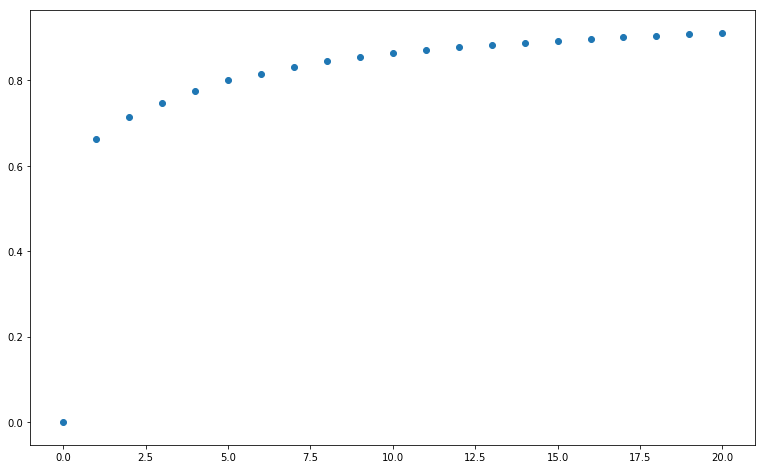

captured by PCA: 91.2%


In [25]:
plt.scatter(x=range(len(pca.explained_variance_ratio_)+1), 
            y=np.insert(pca.explained_variance_ratio_.cumsum(), 0, 0))
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_)*100:0.1f}%")

In [26]:
np_pca = pca.transform(all_df[cols_kmers])
df_pca = pd.DataFrame(np_pca, columns=cols_pca)
df_pca = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_pca], axis=1) # , ignore_index=True)
df_pca["color_map"] = 0
for i, bacteria in enumerate(df_pca.bacteria.unique()):
    df_pca.loc[df_pca["bacteria"] == bacteria, ['color_map']] = i
df_pca.shape

(953798, 25)

In [18]:
df_pca.sample(1000).plot.scatter(x="pca_1", y="pca_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_[:2])*100:0.1f}%")

NameError: name 'df_pca' is not defined

In [28]:
df_pca.sample(3)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map
913102,Bradyrhizobium_japonicum_USDA_6_uid158851,NC_017249,9207384,8810000,-0.035,0.003,-0.006,0.002,0.010,-0.002,...,-0.002,0.002,-0.001,0.002,-0.001,0.003,0.001,-0.000,0.001,2669
473725,Neisseria_meningitidis_M01_240149_uid162079,NC_017514,2223518,1670000,-0.001,-0.002,-0.009,0.001,0.001,-0.005,...,0.004,-0.002,0.004,0.004,-0.004,-0.005,0.001,-0.001,-0.002,1386
95389,Desulfovibrio_vulgaris_RCH1_uid161961,NC_017310,3532052,230000,-0.037,-0.004,0.005,0.001,-0.002,0.002,...,0.002,-0.004,-0.008,-0.001,-0.007,-0.003,0.001,0.003,-0.000,294


In [12]:
df_pca = pd.read_pickle("/home/ubuntu/TMP/pca_data_953798_20_float.pd")

# Clustering

https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb

In [13]:
import sklearn.cluster as cluster
import scipy.cluster.hierarchy as sch
import seaborn as sns
import hdbscan

In [14]:
df_pca.shape

(953798, 26)

In [15]:
x = df_pca.sample(10000)

In [16]:
x.sample(3)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster
761425,Rhodospirillum_rubrum_F11_uid162149,NC_017584,4352825,1610000,-0.037,0.002,0.004,-0.006,-0.004,-0.006,...,0.003,0.004,0.006,0.003,-0.001,0.000,-0.001,-0.006,2233,3
210822,Corallococcus_coralloides_DSM_2259_uid157997,NC_017030,10080619,3340000,-0.041,0.001,0.009,0.000,0.002,-0.005,...,-0.003,-0.005,-0.002,0.001,-0.001,-0.001,0.005,0.003,635,3
442389,Lactococcus_lactis_cremoris_KW2_uid219629,NC_022369,2427048,1150000,0.047,0.006,0.000,-0.008,-0.000,-0.003,...,-0.002,-0.001,-0.003,0.003,0.002,0.003,0.003,-0.002,1299,1


In [17]:
now = lambda : dt.now().strftime("%Y-%m-%d_%H-%M")

In [18]:
now()

'2019-06-18_02-41'

In [19]:
n_clusters = 10

In [20]:
# sns.set_context('poster')
sns.set_context("paper")
# sns.set_context("notebook", font_scale=1.25)
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}

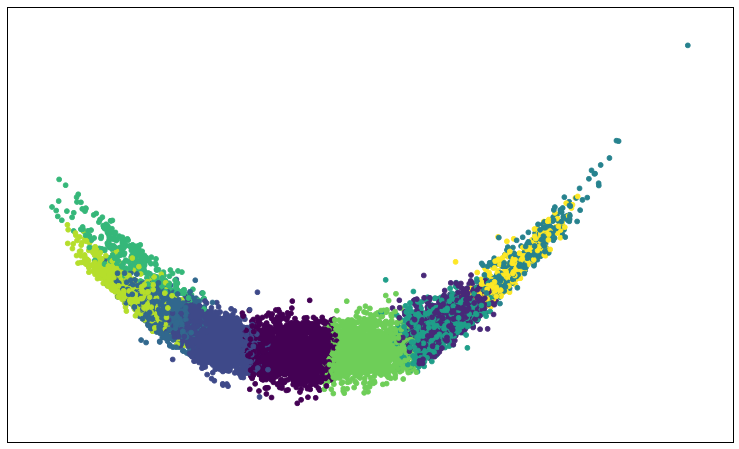

In [21]:
plt.scatter(x.pca_1, x.pca_2, c=x.cluster)  #, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [26]:
df_pca.sample(3)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster
907496,Isosphaera_pallida_ATCC_43644_uid62207,NC_014962,5472964,4520000,-0.024,-0.007,0.007,0.006,0.009,0.000,...,0.002,-0.004,0.000,0.008,-0.001,-0.000,-0.003,-0.003,2653,2
61385,Bacteroides_xylanisolvens_XB1A_uid197168,NC_021017,5976145,140000,0.030,-0.004,0.001,-0.002,0.003,0.003,...,-0.005,0.001,-0.004,-0.000,0.001,-0.001,-0.000,0.002,184,1
8415,Actinoplanes_friuliensis_DSM_7358_uid226110,NC_022657,9376071,9130000,-0.052,0.010,0.010,0.004,0.002,0.005,...,0.002,0.003,-0.007,-0.000,0.003,0.001,0.002,0.002,23,8


In [69]:
bac_sample = df_pca.sample(5).bacteria.unique().to_list()

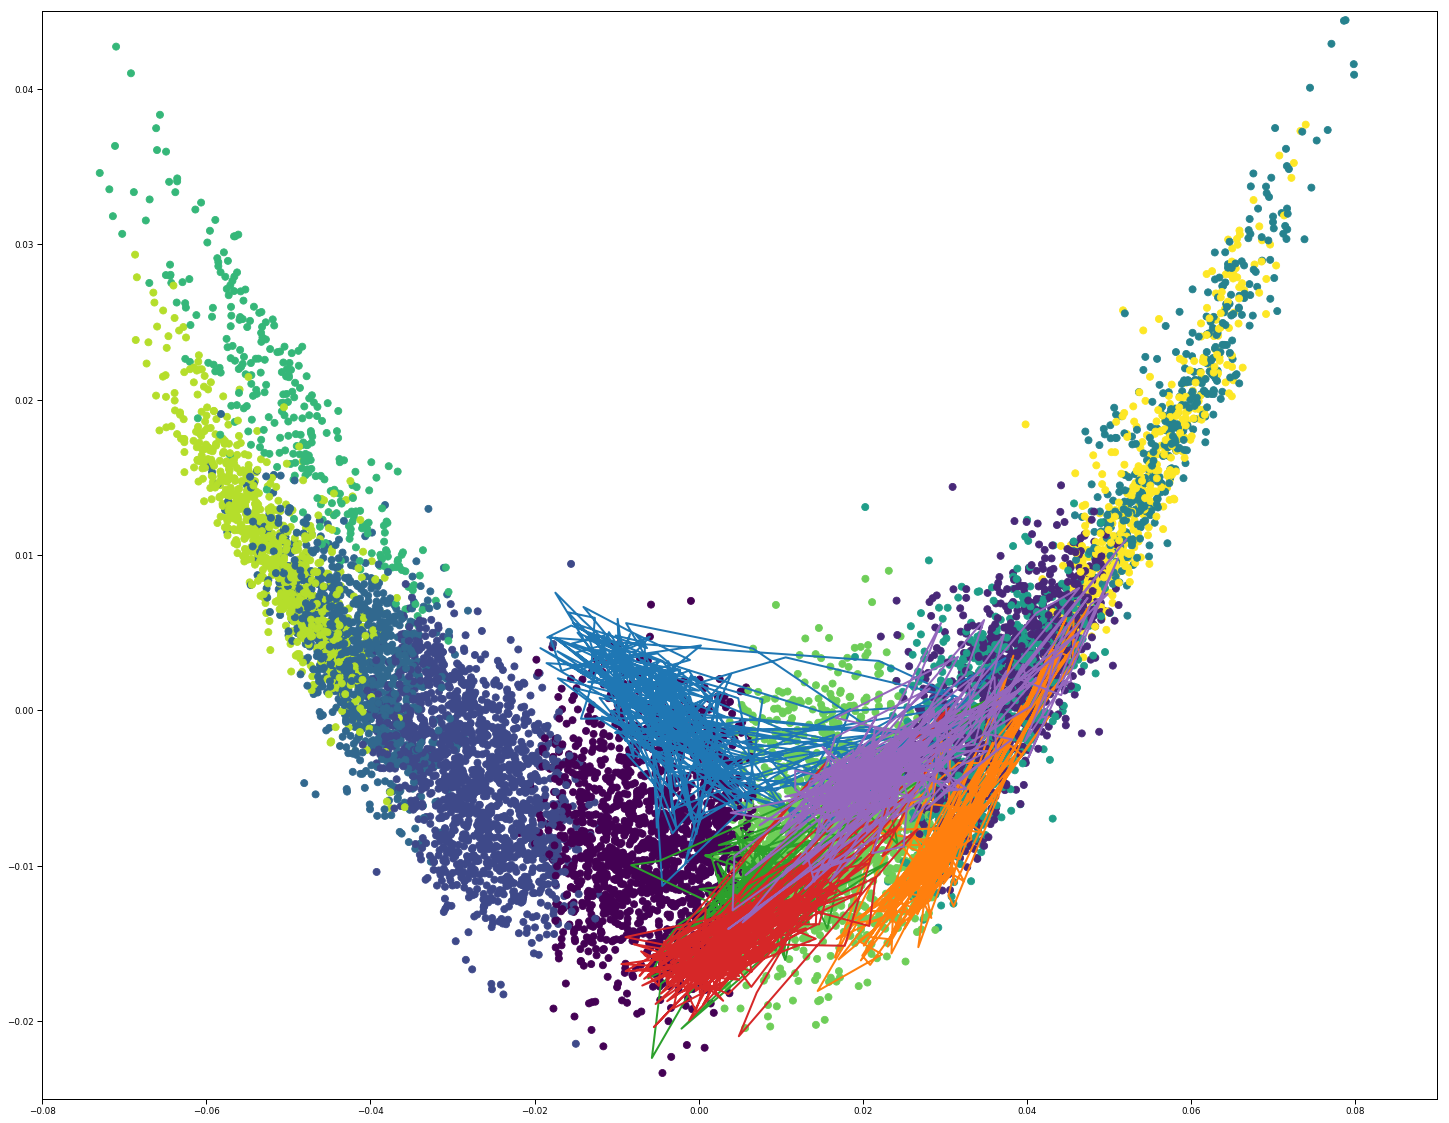

In [70]:
# sns.scatterplot(
#     x="pca_1", y="pca_2",
#     data=x,
#     hue="cluster",
#     palette=sns.color_palette("hls", 10),
#     legend="full",
#     alpha=0.3
# )
# fig  = plt.figure(figsize=(25,20))
plt.figure(figsize=(25,20))
plt.axis([-0.08, 0.09, -0.025, 0.045])

plt.scatter(x.pca_1, x.pca_2, c=x.cluster, s=50)

for bac in bac_sample:
    longest = df_pca[df_pca["bacteria"] == bac].len_genome.max()
    plt.plot('pca_1', 'pca_2', linewidth=2.0, 
              data=df_pca[(df_pca.bacteria == bac) & 
                          (df_pca.len_genome == longest)])


In [22]:
def compute_clusters(data, algorithm, args, kwds, col_plot=(0,1)):
    start_time = time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time()
    return labels

In [23]:
def plot_clusters(data):
    sample = data.sample(1000)
    
    palette = sns.color_palette('deep', np.unique(sample.cluster).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in sample.cluster]
    
    plot_kwds = {'alpha' : 0.25, 's' : 20, 'linewidths':0}
    
    plt.scatter(sample.pca_1, sample.pca_2, c=colors, **plot_kwds)
#     sns.scatterplot(x=sample.columns[0], y=sample.columns[1], data=sample, legend="full", **plot_kwds)
#     frame = plt.gca()
#     frame.axes.get_xaxis().set_visible(False)
#     frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

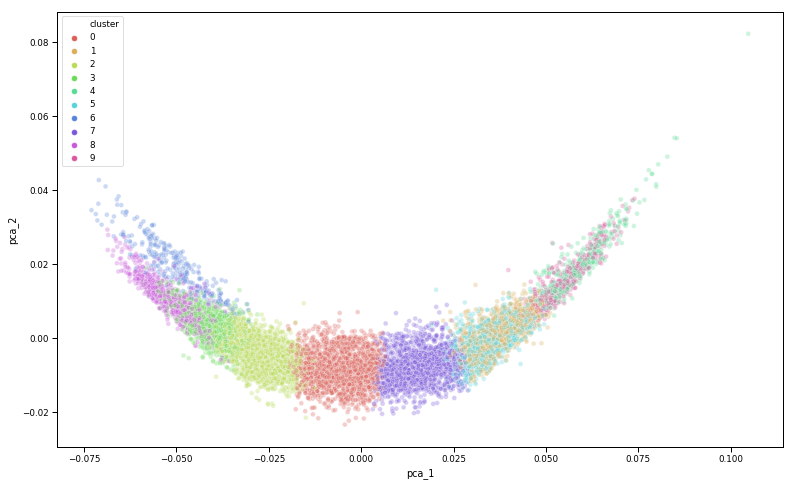

In [24]:
sns.scatterplot(
    x="pca_1", y="pca_2",
    data=x,
    hue="cluster",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

In [25]:
df_pca.sample(5)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster
466959,Pseudomonas_monteilii_SB3101_uid232253,NC_023076,5945120,2440000,-0.035,-0.007,-0.001,-0.001,-0.019,0.000,...,0.002,-0.004,-0.004,-0.001,-0.007,-0.001,-0.000,0.002,1365,3
861607,Alicyclobacillus_acidocaldarius_DSM_446_uid59199,NC_013205,3018755,1320000,-0.033,0.000,-0.002,-0.005,0.008,-0.002,...,-0.001,-0.005,0.006,0.002,-0.000,-0.004,0.001,-0.002,2521,2
579562,Bifidobacterium_longum_JCM_1217_uid62695,NC_015067,2385164,2070000,-0.026,-0.005,-0.000,0.005,0.000,0.005,...,-0.003,-0.000,-0.001,-0.004,-0.002,0.002,-0.002,-0.001,1706,2
74124,Prosthecochloris_aestuarii_DSM_271_uid58151,NC_011059,2512923,1830000,0.009,-0.011,0.000,0.002,0.007,-0.005,...,0.000,-0.002,0.002,0.000,0.003,0.002,0.003,0.001,224,7
794356,Clostridium_difficile_R20291_uid40921,NC_013316,4191339,2410000,0.060,0.018,0.006,-0.002,-0.004,0.004,...,-0.001,-0.001,0.001,-0.003,-0.001,0.002,-0.004,-0.003,2328,4


In [34]:
x.shape

(10000, 26)

## t-SNE

In [36]:
def compute_tsne(data, labels, perplexity=30, n_iter=1000):
    X_embedded = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter).fit_transform(data)
    tsne_df = pd.DataFrame(X_embedded, columns=["component1", "component2"], index=data.index)
    tsne_df["cluster"] = labels
#     data["component1"] = X_embedded[:,0]
#     data["component2"] = X_embedded[:,1]
    return tsne_df

In [37]:
def save_plot_tsne(tsne_df, perplexity):
    plt.figure()
    ax = sns.scatterplot(
            x="component1", y="component2",
            data=tsne_df,
            hue="cluster",
            palette=sns.color_palette("hls", 10),
            legend="full",
            alpha=0.3,
    )
    ax.set_title(f"t-SNE with perplexity:{perplexity} and n_iter={n_iter}")
    plt.savefig(f"/home/ubuntu/Data/Presentations/Clustering_t-SNE/plot-perplexity_{perplexity:03}-n_iter_{n_iter:04}.png")
    print(f"Saved figure: plot-perplexity_{perplexity:03}-n_iter_{n_iter:04}.png")
    # plt.show()

In [39]:
dat = df_pca.sample(200)
n_iter=1000
for perplex in tqdm([2, 5, 10, 20, 30, 50, 70, 95, 100]):
    tsne_df = compute_tsne(dat[cols_pca], dat[["cluster"]], perplexity=perplex)
#     save_plot_tsne(tsne_df, perplex)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.002s...
[t-SNE] Computed neighbors for 200 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.004020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.926468
[t-SNE] KL divergence after 1000 iterations: 0.536656
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.006956
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.627556
[t-SNE] KL divergence after 1000 iterations: 0.565988
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.009036
[t-SNE] KL divergence after 250 iteration

Learn the clusters

## Checking if clusters make sense
counting windows of genomes per cluster (how are they split)

In [188]:
def windows_counts_plot():
    # computing values
    x_val = []
    y_val = []
    bac_name = []
    plot_x = 3; plot_y = 4
    nb_examples = plot_x * plot_y
    for bac in random.choices(df_pca.bacteria.unique(), k=nb_examples):
        clusters = Counter(df_pca[(df_pca.bacteria == bac) & (df_pca.genome_plasmid == "genome")].cluster)
        clusters = dict(clusters)
        for key in range(10):
            if key not in clusters.keys():
                clusters[key] = 0
        x_val.append(list(clusters.keys()))
        y_val.append(list(clusters.values()))
        bac_name.append(bac)
    
    # plotting
    plt.figure()
    for i in range(nb_examples):
        plt.subplot(plot_x, plot_y, i+1)
        sns.barplot(x_val[i], y_val[i])
        plt.title("_".join(bac_name[i].split("_")[0:2]))

        if i+1 == 10: plt.xlabel("Cluster ID")
        if i+1 == 5: plt.ylabel("# windows assigned")

        if i+1 >= 9: plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        else:        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


In [40]:
sns.set_context("paper")

Saved figure: 00.png
Saved figure: 01.png
Saved figure: 02.png
Saved figure: 03.png
Saved figure: 04.png
Saved figure: 05.png
Saved figure: 06.png
Saved figure: 07.png
Saved figure: 08.png
Saved figure: 09.png


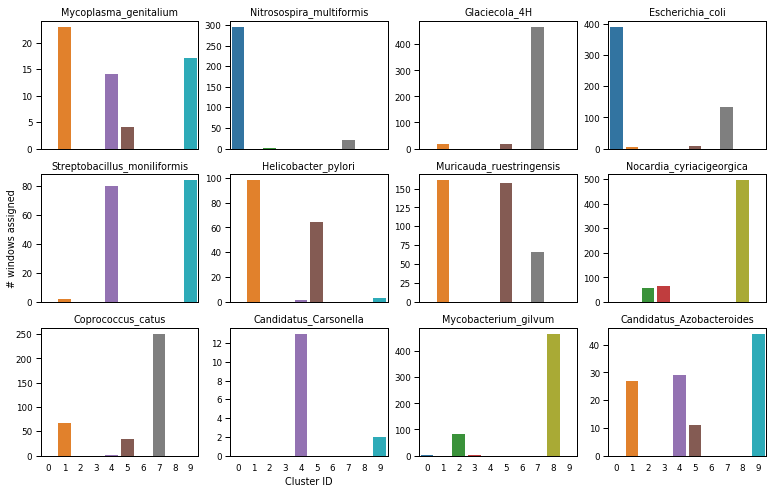

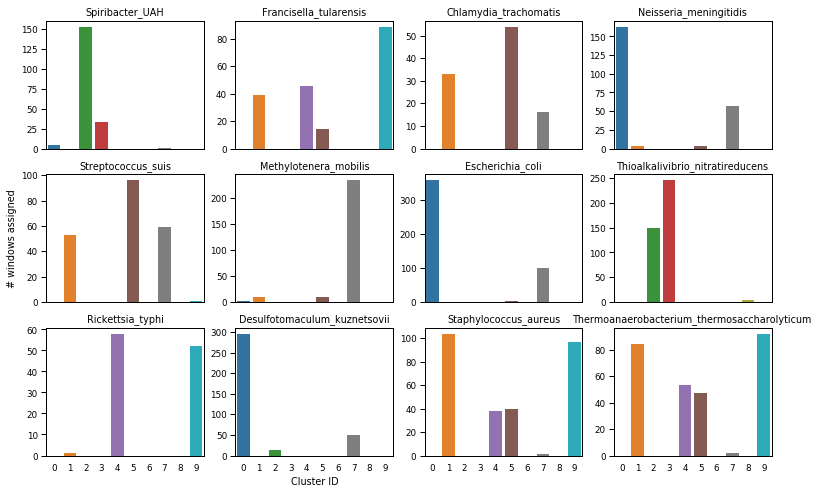

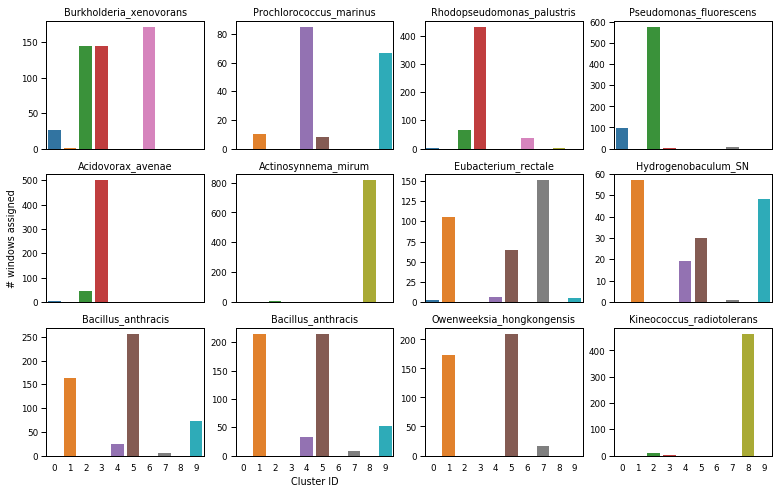

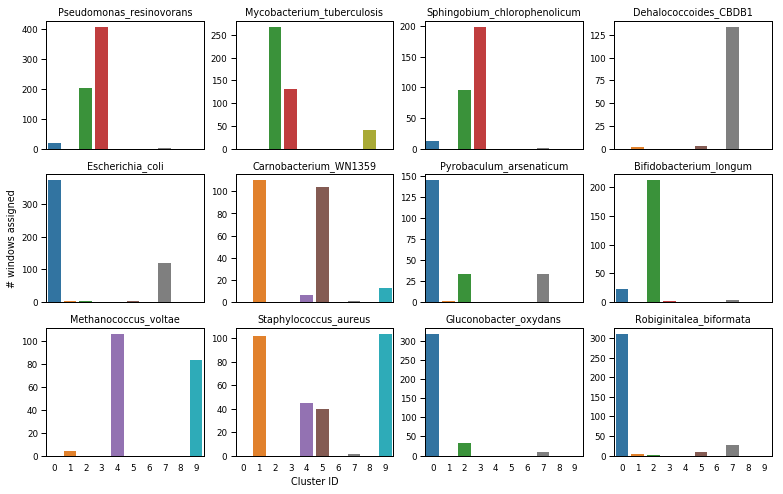

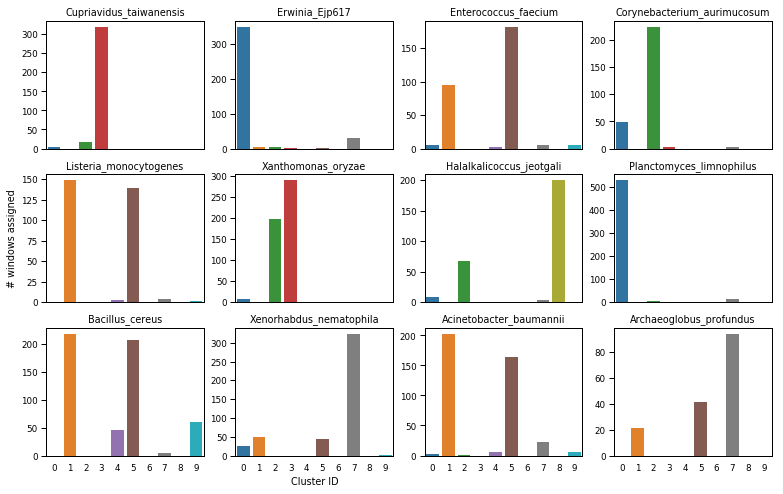

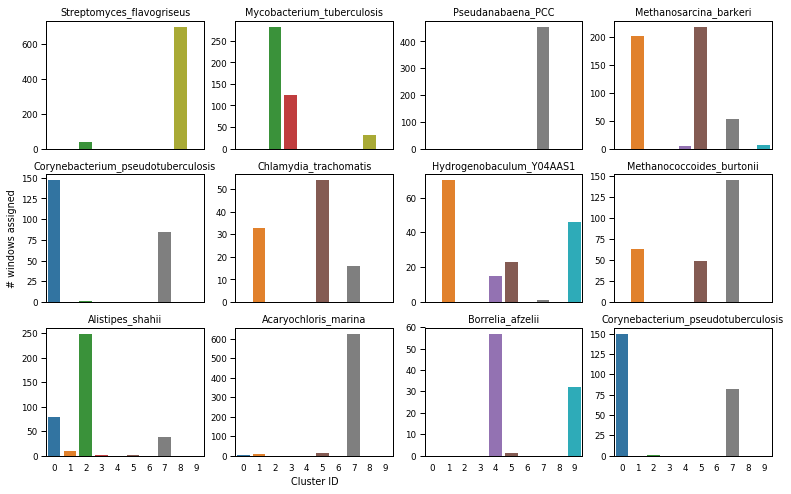

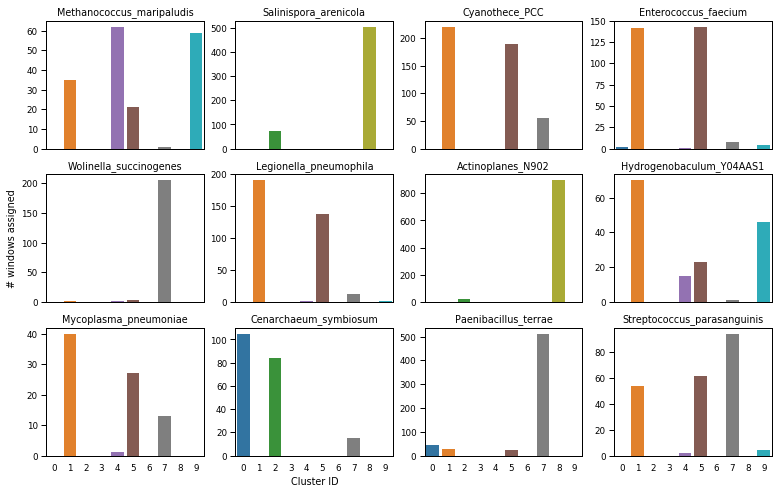

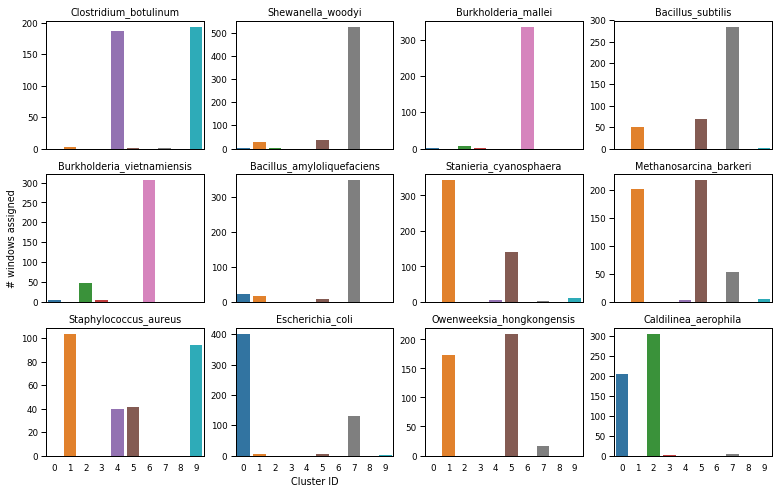

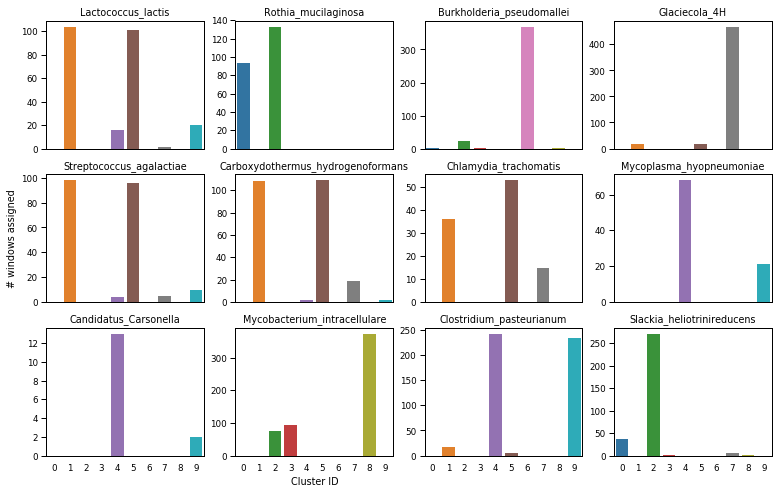

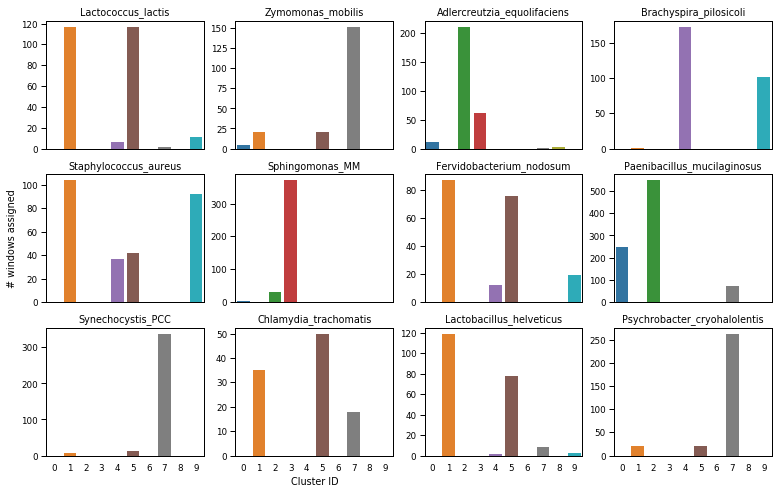

In [190]:
for i in tqdm(range(10)):
    windows_counts_plot()
    plt.savefig(f"/home/ubuntu/Data/Presentations/genomes_window_counts/{i:02}.png")
    print(f"Saved figure: {i:02}.png")

## K Means

In [65]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [43]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=seed)

'2019-05-16_06-35'

In [64]:
df_pca.head(3)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster,y_km
0,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,0,-0.012,-0.015,0.008,0.001,0.010,0.007,...,-0.004,-0.003,-0.001,0.002,0.004,0.001,-0.002,0,0,0
1,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,10000,-0.019,-0.011,0.006,-0.002,0.011,0.010,...,-0.005,-0.002,-0.000,0.000,0.002,0.003,-0.002,0,2,0
2,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,20000,-0.008,-0.015,0.003,-0.002,0.011,0.006,...,-0.004,-0.001,0.000,0.001,0.001,0.001,-0.002,0,0,4


In [63]:
all_df.head(3)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,0,20.000,24.000,19.000,26.000,15.000,43.000,...,38.000,25.000,47.000,52.000,40.000,26.000,6.000,28.000,29.000,28.000
1,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,10000,16.000,16.000,23.000,14.000,22.000,28.000,...,45.000,17.000,41.000,35.000,40.000,18.000,11.000,24.000,17.000,9.000
2,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,20000,18.000,21.000,26.000,16.000,26.000,23.000,...,53.000,43.000,44.000,50.000,58.000,52.000,14.000,46.000,43.000,37.000


In [50]:
start = time()
kmeans.fit(df_pca[cols_pca])
print(f"took {time() - start:.2f} s")

took 69.90 s


In [52]:
y_km = kmeans.predict(df_pca[cols_pca])

In [57]:
df_pca["y_km"] = y_km

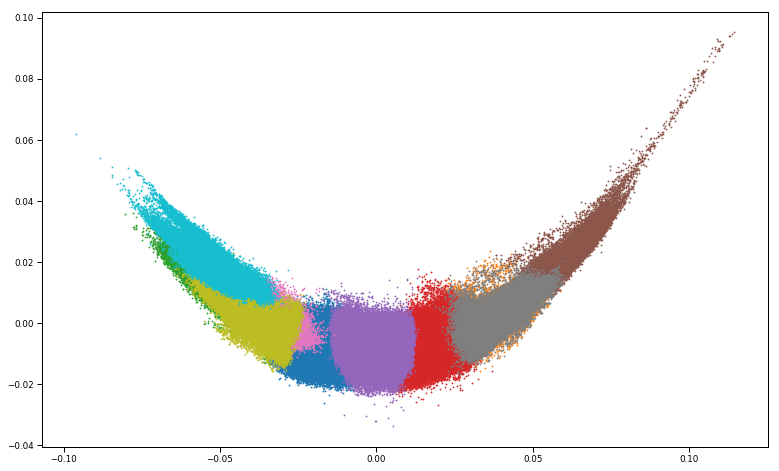

In [54]:
for c in range(n_clusters):
    plt.scatter(df_pca["pca_1"][y_km == c], df_pca["pca_2"][y_km == c], s=1)

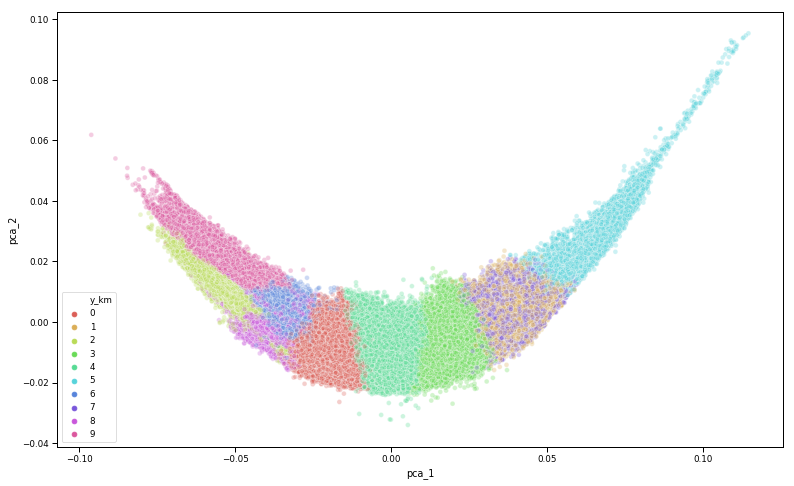

In [58]:
sns.scatterplot(
    x="pca_1", y="pca_2",
    data=df_pca,
    hue="y_km",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

In [98]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_kmeans_{now()}.pkl", 'wb') as f: 
    pickle.dump(kmeans, f)

## Agglomerate clustering

In [77]:
data = x[cols_lda].sample(10000)

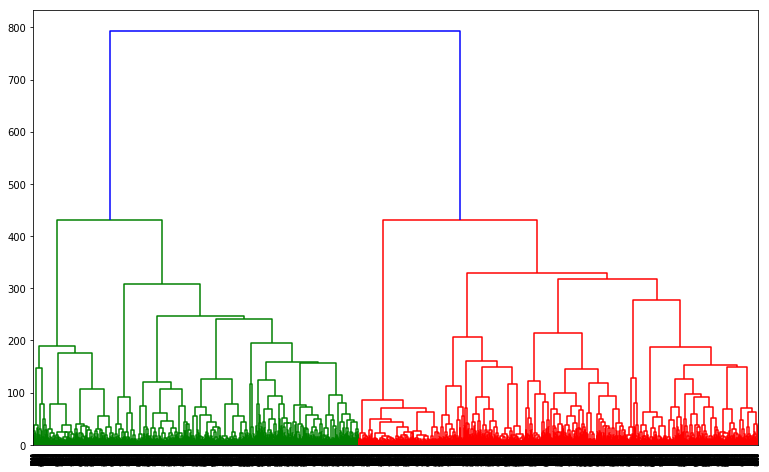

In [78]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
# create clusters
print("Create clusters...")
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
print("save them")
y_hc = hc.fit_predict(data)

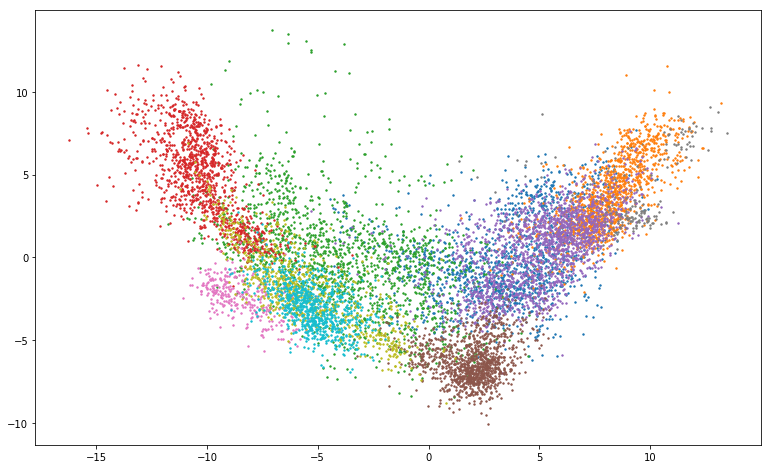

In [81]:
for c in range(n_clusters):
    plt.scatter(data["lda_1"][y_hc == c], data["lda_2"][y_hc == c], s=2)

In [85]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_agglo_{now()}.pkl", 'wb') as f: 
    pickle.dump(hc, f)

## Mini Batch KMeans

In [66]:
minikm = MiniBatchKMeans(n_clusters=n_clusters, random_state=seed, batch_size=1000, max_iter=100)

In [77]:
start = time()
minikm.fit(all_df[cols_kmers])
print(f"took {time() - start:.2f} s")

took 7.63 s


In [79]:
y_mini = minikm.predict(all_df[cols_kmers])

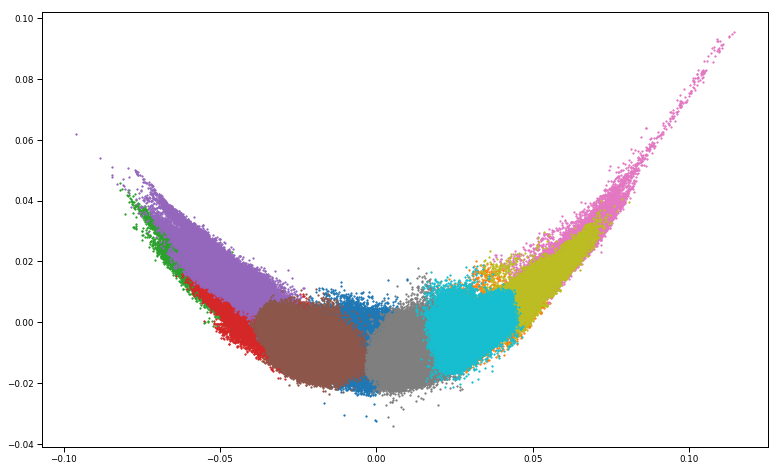

In [80]:
for c in range(n_clusters):
    plt.scatter(df_pca["pca_1"][y_mini == c], df_pca["pca_2"][y_mini == c], s=2)

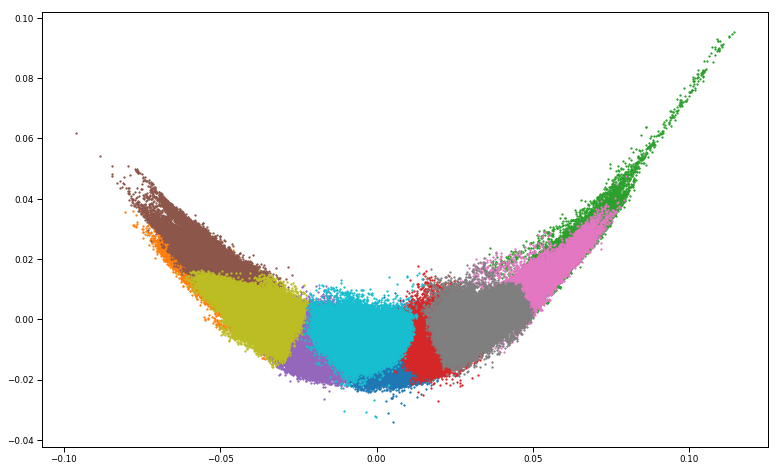

In [73]:
for c in range(n_clusters):
    plt.scatter(df_pca["pca_1"][y_mini == c], df_pca["pca_2"][y_mini == c], s=2)

In [75]:
row_sums = all_df[cols_kmers].sum(axis=1)
row_sums[row_sums == 0] = 1.0

In [76]:
all_df[cols_kmers] = all_df[cols_kmers].div(row_sums, axis=0)

## Combining results

In [104]:
class Cluster:
    def __init__(self, name, model, prediction):
        self.name = name
        self.model = model
        self.pred = prediction
        

In [105]:
models = [
    Cluster("kmeans", kmeans, y_km),
    Cluster("agglo", hc, y_hc),
    Cluster("minikm", minikm, y_mini),
]

# Evaluation

In [113]:
[len(model.pred) for model in models]

[953797, 10000, 953797]

In [110]:
pd_pred = pd.DataFrame({
    model.name: model.pred for model in models
})

ValueError: arrays must all be same length



### End of the script.
Sylvain @GIS

In [ ]:
ranking_ml(pd_res, 1000)

In [ ]:
pd_res

In [ ]:
pd_res[f"RF_pred"].str.split("_", 2).str[1]

In [ ]:
pd_res.Ground_Truth.str.split("_", 1).str[0] == pd_res[f"RF_pred"].str.split("_", 1).str[0]

In [ ]:
pd_res.Ground_Truth == pd_res[f"RF_pred"]

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
n_samples = 10000
n_bacteria = 100
random_seed = 0
dim_reduc_tool = "PCA"
components = 10
test_ratio = 0.1

In [ ]:
name_run = f"_{dim_reduc_tool}-{components}_{n_samples}-samples_{n_bacteria}-bac"

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
y = all_df["bacteria"]
x = all_df[cols_kmers]

In [ ]:
# average each row ?

In [ ]:
x, y = dim_reduc[dim_reduc_tool](x, y, components)

In [ ]:
x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=random_seed)

In [ ]:
models_names = ['RF', 'SVM_lin', 'SVM_rbf', 'KNeigh', 'DTree', 'NNet', 'Naive_Bayes', 'QDA']

In [ ]:
results = launch_models(models_names, X_train, y_train, X_test, y_test, path_models, )  # name_run

In [ ]:
pd_res = pred_accuracy(results, y_test)
pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
pd_res.shape

In [ ]:
pd_ranking = ranking_ml(pd_res, test_ratio * n_samples)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

In [ ]:
class subSample:
    """ Attempt to use Pipeline correctly
        Select a subset of the available bacteria, and subsample again a number of windows
    """
    
    def __init__(self, n_samples=10000, n_species=100, random_state=0):
        self.n_samples = n_samples
        self.n_species = n_species
        self.random_state = random_state
        self._queried = None
        
    def fit(self, X, y):
        assert len(X) > self.n_samples, f"Dataset has less rows ({len(X)}) than the requested number of samples"
        assert len(y.unique()) > self.n_species, f"Dataset has less number of species "\
                                                 f"({len(y.unique())}) than the requested number of samples"
        if self.n_species < 0:
            self._queried = y.index
        else:
            self._queried = y[y.values.isin(y.unique()[:self.n_species])].index
        return self
    
    def transform(self, X, y=None):
        if y is None:
            if self.n_samples < 0:
                return X.iloc[self._queried]
            return X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state)
        else:
            if self.n_samples < 0:
                return (X.iloc[self._queried],
                        y.iloc[self._queried]
                       )
            return (X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state),
                    y.iloc[self._queried].sample(self.n_samples, random_state=self.random_state))
        
        return 
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)

In [ ]:
subSam = subSample()

In [ ]:
subSam.fit(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
X, y = subSam.fit_transform(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
res[0].shape

In [ ]:
n_samples = 10000
n_bacteria = 100

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
all_all_df.shape, all_df.shape

In [ ]:
# Raw data
X_train, X_test, y_train, y_test = train_test_split(scale(all_df[cols_kmers]), all_df.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
y_test = all_all_df["bacteria"]

In [ ]:
queried = y_test[y_test.values.isin(y_test.unique()[:n_bacteria])].index

In [ ]:
all_all_df.iloc[queried].sample(5).shape

## Machine Learning classification

In [ ]:
cols_spe

In [ ]:
# With LDA
X_train, X_test, y_train, y_test = train_test_split(scale(df_lda[cols_pca]), df_lda.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
models = {
    "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
    "SVM_lin": SVC(kernel="linear", C=0.025),
    "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),
    "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
    "DTree": DecisionTreeClassifier(max_depth=20),
    "NNet": MLPClassifier(alpha=1),
#     "AdaBoost": AdaBoostClassifier(),  # worse classifier
    "Naive_Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [ ]:
results = {}

In [ ]:
for name in tqdm(models.keys()):
    if name not in results.keys():
        print(name)
        start = time()
        results[name] = {}
        
        models[name].fit(X_train, y_train)
        time_fitted = time()
        results[name]["time_fit"] = time_fitted - start
        
        predicted = models[name].predict(X_test)
        results[name]["predicted"] = predicted
        time_predicted = time()
        results[name]["time_predict"] = time_predicted - time_fitted
        
#         score = models[name].score(X_test, y_test)
#         results[name]["score"] = score
#         results[name]["time_score"] = time() - time_predicted
        
        results[name]["time"] = time() - start
    

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
name_run = f"_LDA40_{n_samples}samples_{n_bacteria}bac"

`name_run = f"_LDA-40_{n_samples}-samples_{n_bacteria}-bac"`

In [ ]:
if True:
    for model in tqdm(models.keys()):
        with open(os.path.join(path_models, f"_{model}_{name_run}.pkl"), 'wb') as f_out:
            pickle.dump(models[model], f_out)

In [ ]:
to_df = {"Ground_Truth": y_test}
for name in results.keys():
    predicted = results[name]["predicted"]
    to_df[f"{name}"] = (y_test==predicted).astype(int)
    to_df[f"{name}_pred"] = predicted
pd_res = pd.DataFrame(to_df)

pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
ranking = 100 * pd_res.sum(numeric_only=True) / pd_res.RF.count()

In [ ]:
pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                           "percentage": ranking.values})

In [ ]:
for times in ("time", "time_fit", "time_predict", ):
    pd_ranking[times] = 0
    for name in results.keys():
        pd_ranking.loc[pd_ranking["name"] == name, [times]] = results[name][times]

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking

## Saved results for various input settings

Results for 100,000 samples from 100 species, NO PCA, 256 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 40 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 10 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, with PCA, 10 features

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

Results for 10,000 samples from 100 species, with PCA

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

In [ ]:
pd_res

In [ ]:
all_df.sample(5)

In [ ]:
all_df[all_df.fna.str.contains("NC")].shape

In [ ]:
all_df.loc[all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"), "fna"].unique()

In [ ]:
all_df[(all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"))].len_genome.unique()

In [ ]:
y_test

In [ ]:
df_pca1000.bacteria



### End of the script.
Sylvain @GIS

## Keep other methods

ML stuff

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
def normalise_counts(kmer_count):
    """Nested dict, normalize each of the sub dict. """
    for window in kmer_count.keys():
        max_val = max(kmer_count[window].values())
        for key in kmer_count[window]:
            kmer_count[window][key] /= max_val